In [8]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
# Load data
df = pd.read_csv("./dataset/train.csv")

# Combine all quotes into a single string
text = " ".join(df["Quotes"].tolist()).lower()
# Tokenize the text
tokenizer.fit_on_texts([text])
sequences = tokenizer.texts_to_sequences([text])[0]

# Define the sequence length and prepare the sequences
max_sequence_len = 5
inputs, targets = [], []

for i in range(len(sequences) - max_sequence_len):
    inputs.append(sequences[i : i + max_sequence_len])
    targets.append([sequences[i + max_sequence_len]])

# pad
inputs_padded = pad_sequences(inputs, maxlen=max_sequence_len, padding="post")
targets_padded = pad_sequences(targets, maxlen=1, padding="post")

# Split into training and validation
split_idx = int(0.8 * len(inputs_padded))
X_train, y_train = inputs_padded[:split_idx], targets_padded[:split_idx]
X_val, y_val = inputs_padded[split_idx:], targets_padded[split_idx:]

print(f"{X_train.shape}, {X_val.shape}, {y_train.shape}, {y_val.shape}")
print(f"{X_train}, {y_train}")

(9504, 5), (2377, 5), (9504, 1), (2377, 1)
[[  19    1   53    2   13]
 [   1   53    2   13   87]
 [  53    2   13   87  408]
 ...
 [ 372   13  676   39  116]
 [  13  676   39  116 1063]
 [ 676   39  116 1063   10]], [[  87]
 [ 408]
 [   5]
 ...
 [1063]
 [  10]
 [   5]]


In [9]:
from tensorflow.keras.utils import to_categorical
num_tokens = len(tokenizer.word_index) + 1

# Convert targets to categorical
y_train = to_categorical(y_train, num_classes=num_tokens)
y_val = to_categorical(y_val, num_classes=num_tokens)

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import tensorflow as tf

class Customlr(LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate):
        super(Customlr, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

    def __call__(self, step):
        return self.initial_learning_rate / (1 + self.decay_rate * tf.math.floor(step / self.decay_steps))
    
    def get_config(self):
            return {
                "initial_learning_rate": self.initial_learning_rate,
                "decay_steps": self.decay_steps,
                "decay_rate": self.decay_rate
                }


vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
rate = 0.6
epochs = 50
batch_size = 128
initial_learning_rate = 0.01
decay_steps = 1000
decay_rate = 0.96
learning_rate_schedule = Customlr(initial_learning_rate, decay_steps, decay_rate)
optimizer = Adam(learning_rate=learning_rate_schedule)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    GRU,
    LSTM,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization
)

# Bidirectional GRU Model
gru_model = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len),
        Bidirectional(GRU(128)),
        Dropout(rate),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax'),
    ]
)
gru_model.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

# Bidirectional LSTM Model
lstm_model = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len),
        Bidirectional(LSTM(128)),
        Dropout(rate),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax'),

    ]
)
lstm_model.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

Epoch 1/50


75/75 [==============================] - 4s 20ms/step - loss: 4.4710 - accuracy: 0.2990 - val_loss: 5.1345 - val_accuracy: 0.2276
Epoch 2/50
75/75 [==============================] - 1s 8ms/step - loss: 2.9378 - accuracy: 0.4393 - val_loss: 5.2053 - val_accuracy: 0.2318
Epoch 3/50
75/75 [==============================] - 1s 9ms/step - loss: 2.3201 - accuracy: 0.5191 - val_loss: 5.5331 - val_accuracy: 0.2638
Epoch 4/50
75/75 [==============================] - 1s 8ms/step - loss: 1.9357 - accuracy: 0.5730 - val_loss: 5.7233 - val_accuracy: 0.2491
Epoch 5/50
75/75 [==============================] - 1s 8ms/step - loss: 1.6806 - accuracy: 0.6121 - val_loss: 5.8670 - val_accuracy: 0.2474
Epoch 6/50
75/75 [==============================] - 1s 7ms/step - loss: 1.5069 - accuracy: 0.6404 - val_loss: 6.2066 - val_accuracy: 0.2398
Epoch 7/50
75/75 [==============================] - 1s 8ms/step - loss: 1.4001 - accuracy: 0.6655 - val_loss: 6.1967 - val_accuracy: 0.2373
Epoch 8/50
75/75 [============

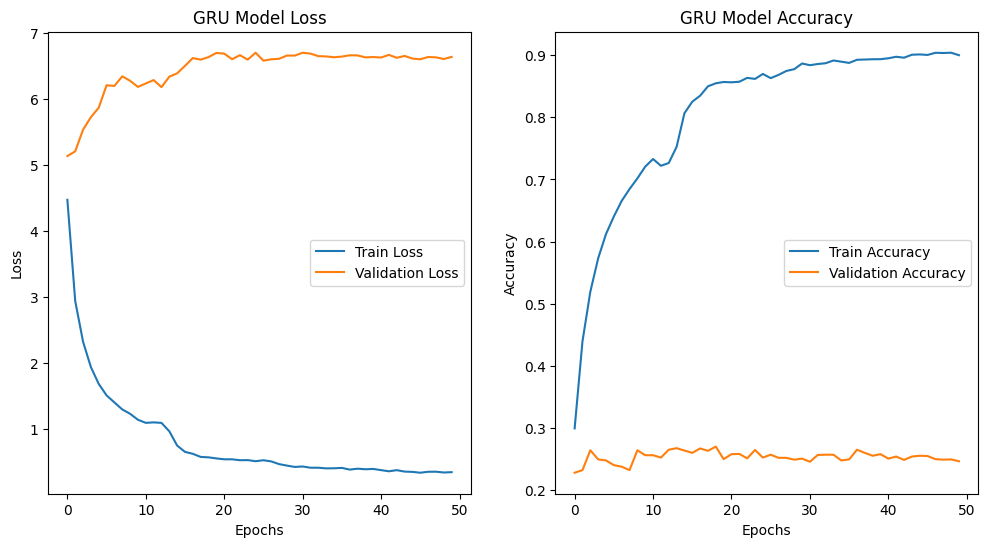

In [12]:
import matplotlib.pyplot as plt

history_gru = gru_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
gru_model.save("gru_model.h5")

# Plotting training and validation loss for GRU model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history["loss"], label="Train Loss")
plt.plot(history_gru.history["val_loss"], label="Validation Loss")
plt.title("GRU Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for GRU model
plt.subplot(1, 2, 2)
plt.plot(history_gru.history["accuracy"], label="Train Accuracy")
plt.plot(history_gru.history["val_accuracy"], label="Validation Accuracy")
plt.title("GRU Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/50
75/75 [==============================] - 3s 17ms/step - loss: 4.6371 - accuracy: 0.2688 - val_loss: 5.1739 - val_accuracy: 0.2150
Epoch 2/50
75/75 [==============================] - 1s 8ms/step - loss: 2.9642 - accuracy: 0.4314 - val_loss: 5.1654 - val_accuracy: 0.2427
Epoch 3/50
75/75 [==============================] - 1s 8ms/step - loss: 2.3063 - accuracy: 0.5226 - val_loss: 5.0882 - val_accuracy: 0.2671
Epoch 4/50
75/75 [==============================] - 1s 8ms/step - loss: 1.8220 - accuracy: 0.5928 - val_loss: 5.2952 - val_accuracy: 0.2823
Epoch 5/50
75/75 [==============================] - 1s 8ms/step - loss: 1.4468 - accuracy: 0.6604 - val_loss: 5.4854 - val_accuracy: 0.2587
Epoch 6/50
75/75 [==============================] - 1s 8ms/step - loss: 1.2339 - accuracy: 0.7021 - val_loss: 5.6658 - val_accuracy: 0.2663
Epoch 7/50
75/75 [==============================] - 1s 8ms/step - loss: 1.0385 - accuracy: 0.7379 - val_loss: 5.8126 - val_accuracy: 0.2692
Epoch 8/50
75/75 [=

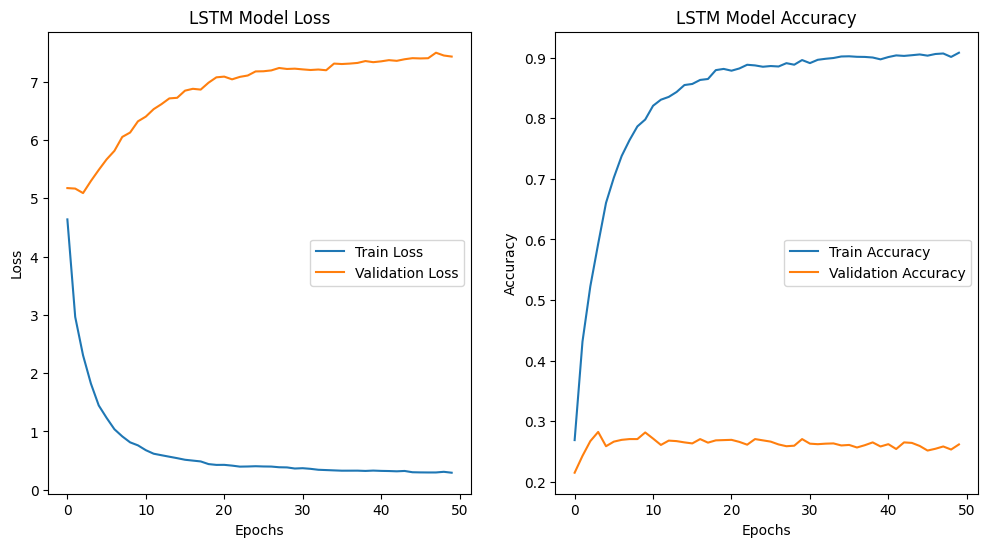

In [13]:
# Train the LSTM model
history_lstm = lstm_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
lstm_model.save("lstm_model.h5")

# Plotting training and validation loss for LSTM model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history["loss"], label="Train Loss")
plt.plot(history_lstm.history["val_loss"], label="Validation Loss")
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for LSTM model
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history["accuracy"], label="Train Accuracy")
plt.plot(history_lstm.history["val_accuracy"], label="Validation Accuracy")
plt.title("LSTM Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
import numpy as np


def generate_text(start_word, model, max_sequence_len, temperature=1, num_words=10):
    # Convert the start word to a tokenized sequence
    sequence = Tokenizer().texts_to_sequences([start_word])[0]
    sequence = pad_sequences([sequence], maxlen=max_sequence_len, padding="post")

    generated = start_word

    # Generating words
    for _ in range(num_words):
        predictions = model.predict(sequence)[0]

        predictions = np.asarray(predictions).astype("float64")
        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        next_word_idx = np.random.choice(len(predictions), p=predictions)

        next_word = tokenizer.index_word[next_word_idx]
        generated += " " + next_word

        sequence = sequence.tolist()[0]
        sequence.append(next_word_idx)
        sequence = sequence[1:]
        sequence = pad_sequences([sequence], maxlen=max_sequence_len, padding="post")

    return generated


# Example usage
generated_text = generate_text('', lstm_model, max_sequence_len, temperature=1, num_words=10)
print(generated_text)

1/1 [==============================] - 0s 16ms/step
 with your soul embrace the power of gratitude for it


===========================================================================================================================================================================


In [18]:
%reset -f

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import tensorflow as tf

class Customlr(LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate):
        super(Customlr, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

    def __call__(self, step):
        return self.initial_learning_rate / (1 + self.decay_rate * tf.math.floor(step / self.decay_steps))
    
    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_steps": self.decay_steps,
            "decay_rate": self.decay_rate
        }
    
data = pd.read_csv("./dataset/train.csv")
text = "\n".join(data["Quotes"]).lower().split('\n')  # Split by new lines
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
vocab_size = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in text:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

if input_sequences:
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
else:
    print("Debug: sequences not generated")

# split
X = input_sequences[:,:-1]
y = to_categorical(input_sequences[:,-1], num_classes=vocab_size)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"{X_train.shape}, {X_val.shape}, {y_train.shape}, {y_val.shape}")
print(f"{X_train}, {y_train}")

(8708, 34), (2178, 34), (8708, 1199), (2178, 1199)
[[  0   0   0 ...  10   5  81]
 [  0   0   0 ...   0   0  15]
 [  0   0   0 ...   1  28   2]
 ...
 [  0   0   0 ...   3 209  10]
 [  0   0   0 ...   1  17   2]
 [  0   0   0 ...   0  13 311]], [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
rate = 0.6
epochs = 100
batch_size = 128
initial_learning_rate = 0.01
decay_steps = 1000
decay_rate = 0.96
learning_rate_schedule = Customlr(initial_learning_rate, decay_steps, decay_rate)
optimizer = Adam(learning_rate=learning_rate_schedule)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    GRU,
    LSTM,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization
)

# Bidirectional GRU Model
gru_model = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1),
        Bidirectional(GRU(128)),
        Dropout(rate),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax'),
    ]
)
gru_model.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

# Bidirectional LSTM Model
lstm_model = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1),
        Bidirectional(LSTM(128)),
        Dropout(rate),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax'),

    ]
)
lstm_model.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

Epoch 1/100
69/69 [==============================] - 3s 19ms/step - loss: 4.7194 - accuracy: 0.2897 - val_loss: 3.7132 - val_accuracy: 0.3935
Epoch 2/100
69/69 [==============================] - 1s 13ms/step - loss: 3.2976 - accuracy: 0.4215 - val_loss: 3.2879 - val_accuracy: 0.4330
Epoch 3/100
69/69 [==============================] - 1s 12ms/step - loss: 2.7757 - accuracy: 0.4692 - val_loss: 3.1981 - val_accuracy: 0.4656
Epoch 4/100
69/69 [==============================] - 1s 13ms/step - loss: 2.4467 - accuracy: 0.5082 - val_loss: 3.0630 - val_accuracy: 0.4812
Epoch 5/100
69/69 [==============================] - 1s 18ms/step - loss: 2.2104 - accuracy: 0.5251 - val_loss: 3.1295 - val_accuracy: 0.4959
Epoch 6/100
69/69 [==============================] - 1s 13ms/step - loss: 2.0613 - accuracy: 0.5516 - val_loss: 3.0847 - val_accuracy: 0.5078
Epoch 7/100
69/69 [==============================] - 1s 12ms/step - loss: 1.9434 - accuracy: 0.5738 - val_loss: 3.1454 - val_accuracy: 0.5041
Epoch 

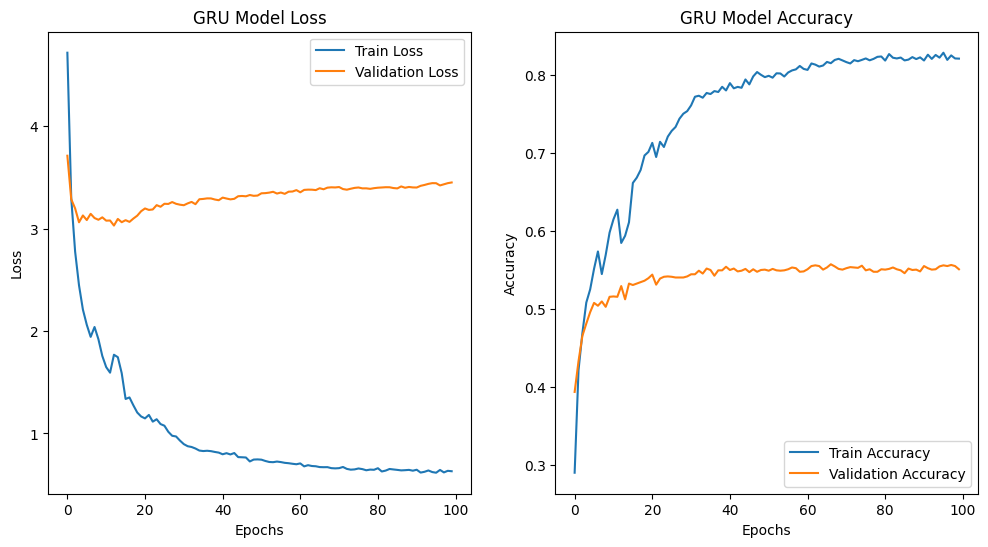

In [22]:
import matplotlib.pyplot as plt

history_gru = gru_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
gru_model.save("gru_model.h5")

# Plotting training and validation loss for GRU model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history["loss"], label="Train Loss")
plt.plot(history_gru.history["val_loss"], label="Validation Loss")
plt.title("GRU Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for GRU model
plt.subplot(1, 2, 2)
plt.plot(history_gru.history["accuracy"], label="Train Accuracy")
plt.plot(history_gru.history["val_accuracy"], label="Validation Accuracy")
plt.title("GRU Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/100
69/69 [==============================] - 4s 22ms/step - loss: 4.9895 - accuracy: 0.2467 - val_loss: 4.6758 - val_accuracy: 0.2984
Epoch 2/100
69/69 [==============================] - 1s 13ms/step - loss: 3.3565 - accuracy: 0.4101 - val_loss: 4.1212 - val_accuracy: 0.3926
Epoch 3/100
69/69 [==============================] - 1s 14ms/step - loss: 2.7534 - accuracy: 0.4789 - val_loss: 3.5873 - val_accuracy: 0.4454
Epoch 4/100
69/69 [==============================] - 1s 14ms/step - loss: 2.3781 - accuracy: 0.5230 - val_loss: 3.1358 - val_accuracy: 0.4697
Epoch 5/100
69/69 [==============================] - 1s 13ms/step - loss: 2.0932 - accuracy: 0.5633 - val_loss: 2.9576 - val_accuracy: 0.4963
Epoch 6/100
69/69 [==============================] - 1s 13ms/step - loss: 1.8841 - accuracy: 0.5906 - val_loss: 2.8726 - val_accuracy: 0.5119
Epoch 7/100
69/69 [==============================] - 1s 13ms/step - loss: 1.7314 - accuracy: 0.6110 - val_loss: 2.8704 - val_accuracy: 0.5253
Epoch 

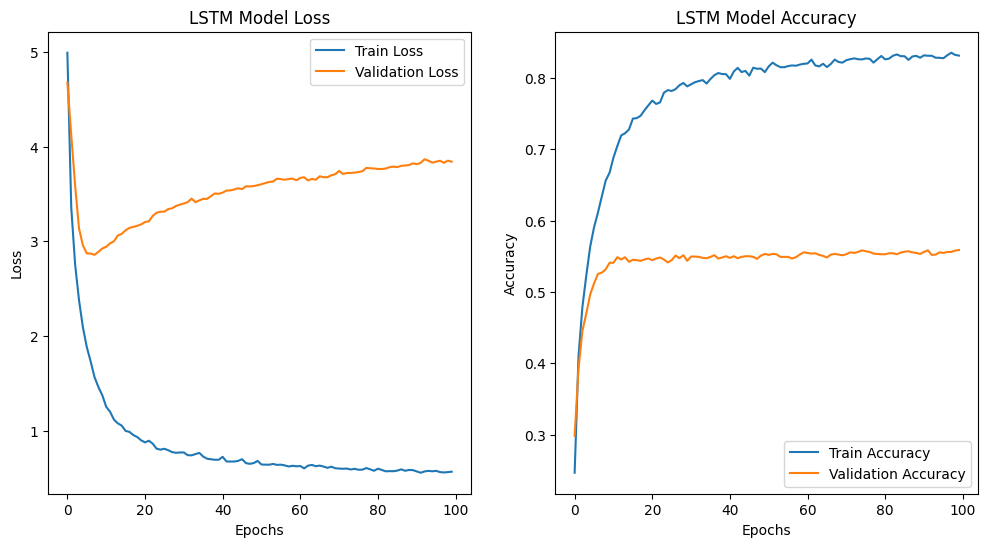

In [23]:
# Train the LSTM model
history_lstm = lstm_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
lstm_model.save("lstm_model.h5")

# Plotting training and validation loss for LSTM model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history["loss"], label="Train Loss")
plt.plot(history_lstm.history["val_loss"], label="Validation Loss")
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for LSTM model
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history["accuracy"], label="Train Accuracy")
plt.plot(history_lstm.history["val_accuracy"], label="Validation Accuracy")
plt.title("LSTM Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
def generate_text(start_word, model, temperature, num_words):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([start_word])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predictions = np.log(predicted_probs) / temperature
        exp_predictions = np.exp(predictions)
        predicted_probs = exp_predictions / np.sum(exp_predictions)
        chosen_word_index = np.random.choice(range(len(predicted_probs)), p=predicted_probs)
        word = tokenizer.index_word[chosen_word_index]
        start_word += " " + word
    return start_word

===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [31]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
rate = 0.6
epochs = 120
batch_size = 64
initial_learning_rate = 0.01
decay_steps = 2000
decay_rate = 0.99
learning_rate_schedule = Customlr(initial_learning_rate, decay_steps, decay_rate)
optimizer = Adam(learning_rate=learning_rate_schedule)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    GRU,
    LSTM,
    Dense,
    Dropout,
    BatchNormalization
)

# Bidirectional LSTM Model
lstm_model2 = Sequential(
    [
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1),
        Bidirectional(LSTM(1024)),
        Dropout(rate),
        BatchNormalization(),
        Dropout(rate),
        Dense(vocab_size, activation='softmax', kernel_regularizer=regularizers.l2(0.01)),
    ]
)

lstm_model2.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [33]:
# Train the LSTM model
history_lstm2 = lstm_model2.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
)
lstm_model2.save("lstm_model2.h5")

# Plotting training and validation loss for LSTM model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm2.history["loss"], label="Train Loss")
plt.plot(history_lstm2.history["val_loss"], label="Validation Loss")
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy for LSTM model
plt.subplot(1, 2, 2)
plt.plot(history_lstm2.history["accuracy"], label="Train Accuracy")
plt.plot(history_lstm2.history["val_accuracy"], label="Validation Accuracy")
plt.title("LSTM Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/120
137/137 [==============================] - 11s 54ms/step - loss: 13.3135 - accuracy: 0.0390 - val_loss: 11.8081 - val_accuracy: 0.1019
Epoch 2/120
137/137 [==============================] - 6s 47ms/step - loss: 10.6136 - accuracy: 0.0606 - val_loss: 9.1377 - val_accuracy: 0.0891
Epoch 3/120
137/137 [==============================] - 6s 40ms/step - loss: 8.3818 - accuracy: 0.0901 - val_loss: 7.7767 - val_accuracy: 0.0978
Epoch 4/120
137/137 [==============================] - 6s 41ms/step - loss: 7.5006 - accuracy: 0.1106 - val_loss: 7.2771 - val_accuracy: 0.1235
Epoch 5/120
137/137 [==============================] - 6s 41ms/step - loss: 6.9894 - accuracy: 0.1329 - val_loss: 6.9199 - val_accuracy: 0.1520
Epoch 6/120
137/137 [==============================] - 6s 41ms/step - loss: 6.7371 - accuracy: 0.1432 - val_loss: 6.6320 - val_accuracy: 0.1800
Epoch 7/120
137/137 [==============================] - 7s 49ms/step - loss: 6.5832 - accuracy: 0.1588 - val_loss: 6.8842 - val_accur

NameError: name 'plt' is not defined

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import tensorflow as tf


class Customlr(LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate):
        super(Customlr, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

    def __call__(self, step):
        return self.initial_learning_rate / (1 + self.decay_rate * tf.math.floor(step / self.decay_steps))
    
    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_steps": self.decay_steps,
            "decay_rate": self.decay_rate
        }
    
data = pd.read_csv("./dataset/train.csv")
text = "\n".join(data["Quotes"]).lower().split('\n')  # Split by new lines
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
vocab_size = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in text:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

if input_sequences:
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
else:
    print("Debug: sequences not generated")

In [2]:
def generate_text(start_word, model, temperature, num_words):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([start_word])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predictions = np.log(predicted_probs) / temperature
        exp_predictions = np.exp(predictions)
        predicted_probs = exp_predictions / np.sum(exp_predictions)
        chosen_word_index = np.random.choice(range(len(predicted_probs)), p=predicted_probs)
        word = tokenizer.index_word[chosen_word_index]
        start_word += " " + word
    return start_word

In [3]:
from tensorflow.keras.models import load_model

lstm_model2 = load_model('lstm_model.h5', custom_objects={'Customlr': Customlr})

In [7]:
print(generate_text('embrace each day', lstm_model2, temperature=0.1, num_words=10))

embrace each day with a heart at peace in new beginnings and strength
